# Project P5: Car Vehicle Detection

## Goals:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
    
    Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
    

* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


### Section 1: defines 

In [1]:
import numpy as np
import pickle
import cv2
import glob
import time
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label


### Section 2: Global configuration parameters

In [2]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pixels_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32
spatial_size = (spatial, spatial)


### Section 3: Data Exploration

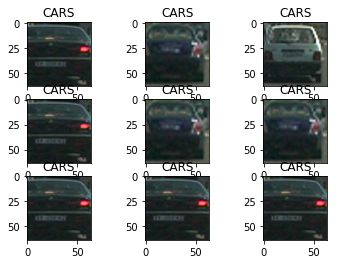

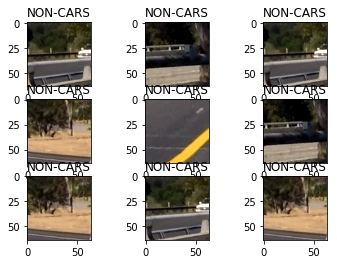

In [3]:
# Load car data and non-car data
cars = glob.glob("vehicles/**/*.png")
others = glob.glob("non-vehicles/**/*.png")

def show_samples(title, list):

    #let's now display a grid of images
    cell_w = 3
    cell_h = 3
    tmp_img, X_img_arr = plt.subplots(cell_w, cell_h)
    idx_row = 0
    for idx in range(0,9):
        col = idx % cell_w
        # plot on relevant subplot
        rand_idx = random.randint(0, len(X_img_arr)) #pick a random image in the dataset
        img = cv2.imread(list[rand_idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X_img_arr[col,idx_row].imshow(img)
        X_img_arr[col,idx_row].set_title(title)
        if col == (cell_w - 1):
             # we have finished the current row, so increment row counter
             idx_row += 1

show_samples("CARS", cars)
show_samples("NON-CARS", others)


### Section 4: HOG feature extraction algorithm

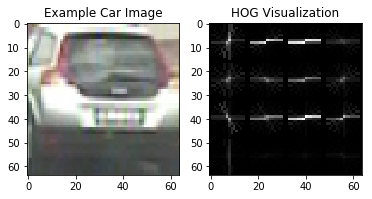

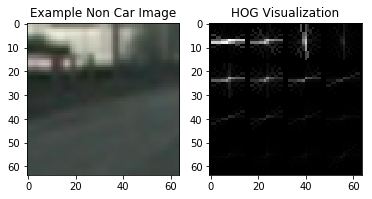

In [4]:
# Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled 
# training set of images

def get_hog_features(img, orient, pix_per_cell=pixels_per_cell, cell_per_block=cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

                              

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pixels_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')


# Generate a random index to look at a NON car image
ind = np.random.randint(0, len(others))
# Read in the image
image = mpimg.imread(others[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pixels_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Non Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

#Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_color(imgs, cspace, spatial_size,
                        hist_bins, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


### Section 5: Simplified Extract Features 

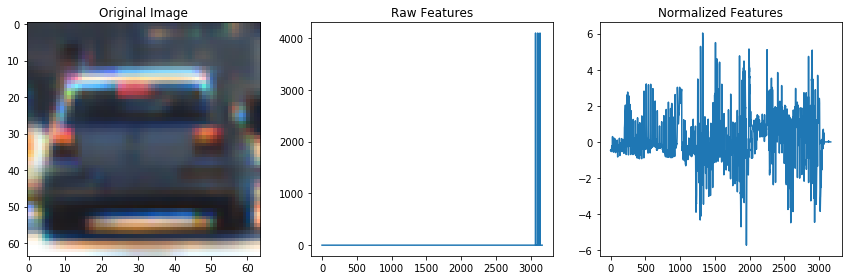

In [6]:

#classifier performs under different binning scenarios

car_features = extract_features_color(cars, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features_color(others, cspace=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

### Section 6: Train SVM classifier on color/spatial features only. How accurate is it?

In [7]:

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc_test = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc_test.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc_test.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc_test.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3168
21.98 Seconds to train SVC...
Test Accuracy of SVC =  0.8936
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  1.  1.  0.  0.]
0.00164 Seconds to predict 10 labels with SVC


###  ** Training is fast, but not so accurate, test accuracy was <90% **

### Section 7: HOG Feature extraction with color/spatial features

In [8]:
##HOG version
def extract_features(imgs, color_space='YUV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

### Goal 1:  Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

Train Classifier
60.67 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 4356
12.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9737
My SVC predicts:  [ 0.  0.  0.  0.  1.  1.  0.  0.  1.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  1.  0.  1.  1.  1.]
0.00241 Seconds to predict 10 labels with SVC


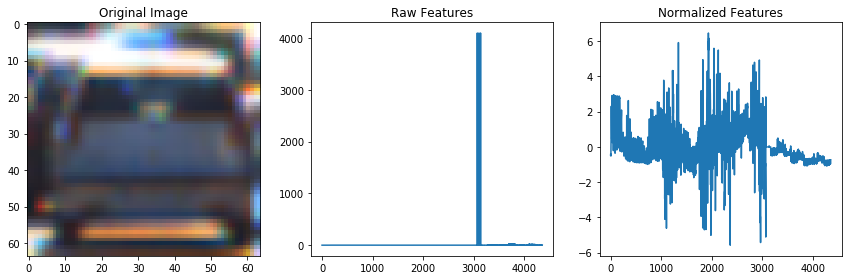

In [9]:
print("Train Classifier")
t=time.time()
car_features = extract_features(cars, colorspace, orient=orient, 
                        pix_per_cell=pixels_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(others, colorspace, orient=orient, 
                        pix_per_cell=pixels_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pixels_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


### Goal 2: Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, 
              svc, 
              X_scaler, 
              orient, 
              pix_per_cell, 
              cell_per_block, 
              spatial_size, 
              hist_bins,
              show_wins=False):
    
    rects = []

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    # Go YUV!
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 

    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_wins == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
     
                rectangle =((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))

                rects.append(rectangle)
                cv2.rectangle(draw_img,rectangle[0], rectangle[1],(0,0,255),6) 

    return draw_img, rects



####  Test sliding window search

(720, 1280, 3)
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
StandardScaler(copy=True, with_mean=True, with_std=True)
11
16
2
(32, 32)
32
5 Boxes in image


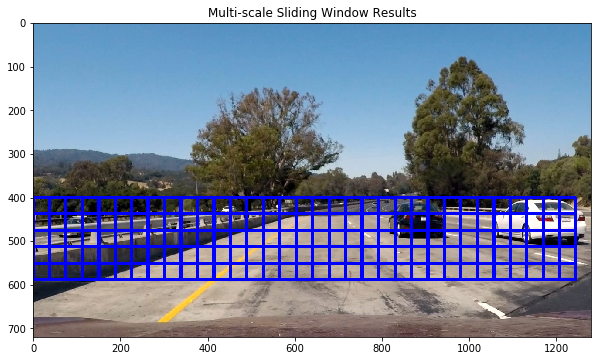

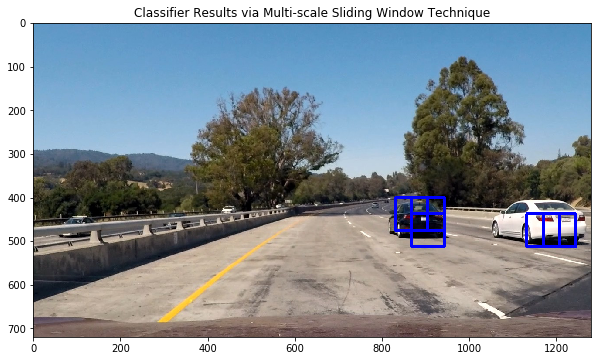

In [11]:
ystart = 400
ystop = 600
scale = 1.18

img = mpimg.imread('./test_images/test1.jpg')
print(img.shape)

print(svc)
print(X_scaler)
print(orient)
print(pixels_per_cell)
print(cell_per_block)
print(spatial_size)
print(histbin)

out_img_win, box_list_win = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                    pixels_per_cell, cell_per_block, spatial_size, histbin, show_wins = True)

plt.figure(figsize=(10,10))
plt.imshow(out_img_win)
plt.title('Multi-scale Sliding Window Results')

out_img, box_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                    pixels_per_cell, cell_per_block, spatial_size, histbin)

plt.figure(figsize=(10,10))
plt.imshow(out_img)
plt.title('Classifier Results via Multi-scale Sliding Window Technique')
print(len(box_list), 'Boxes in image')

### Goal 3 & 4: Develop Heatmaps and Bounding Boxes of Vehicles

2 Objects found


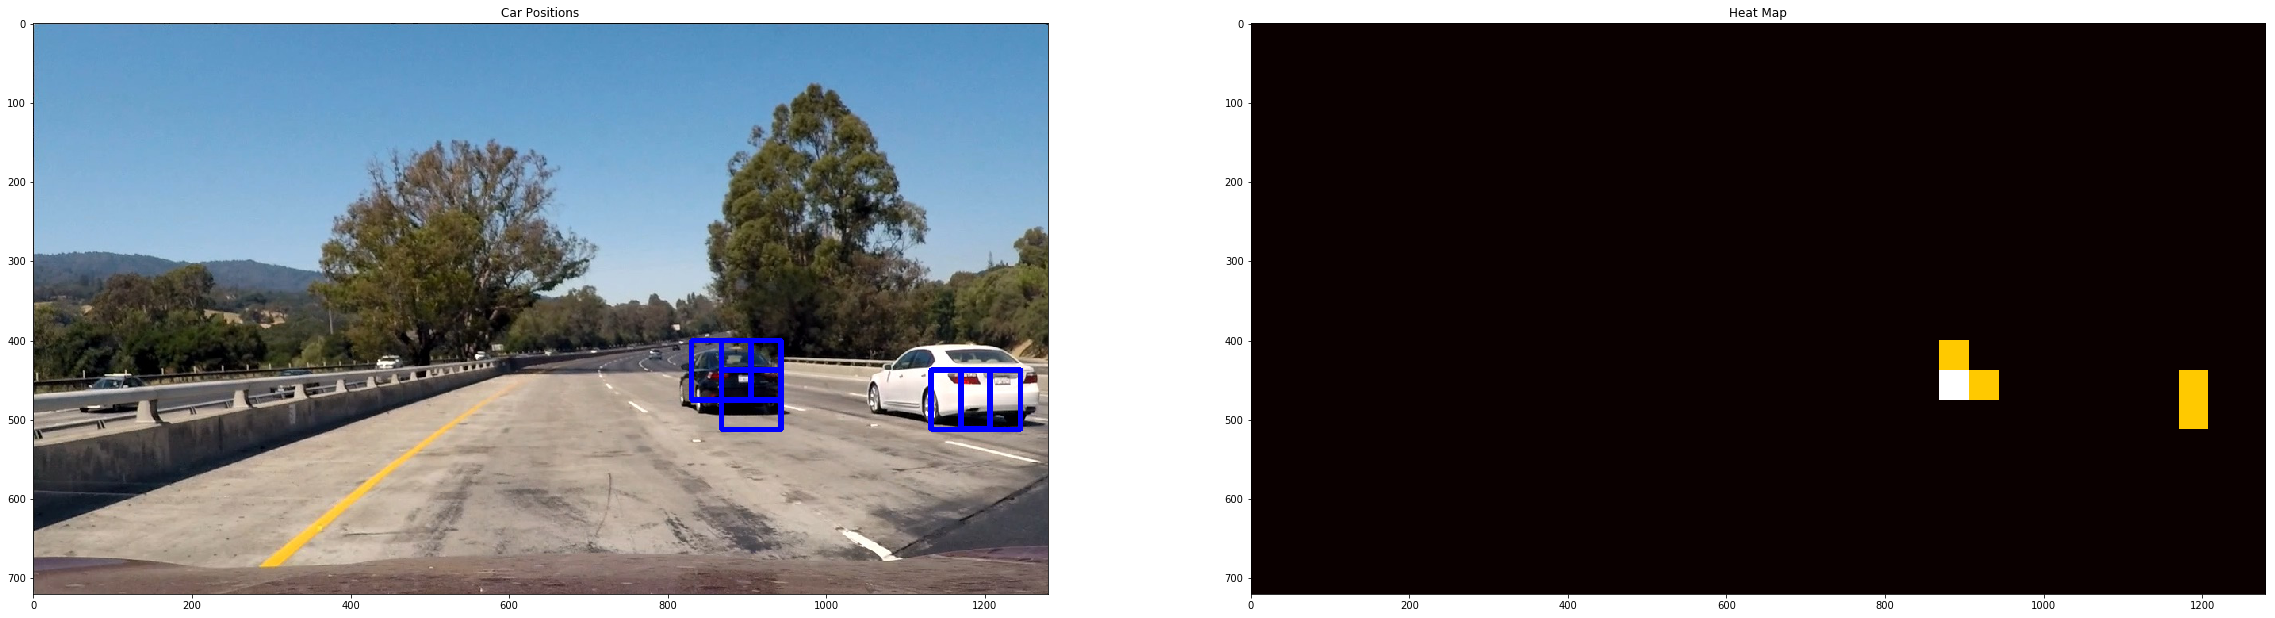

In [12]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        #print (box[0][0], "::", box[0][1], "::",box[1][0], "::", box[1][1])

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(out_img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(out_img), labels)

plt.figure(figsize=(40,40))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
print(labels[1], 'Objects found')



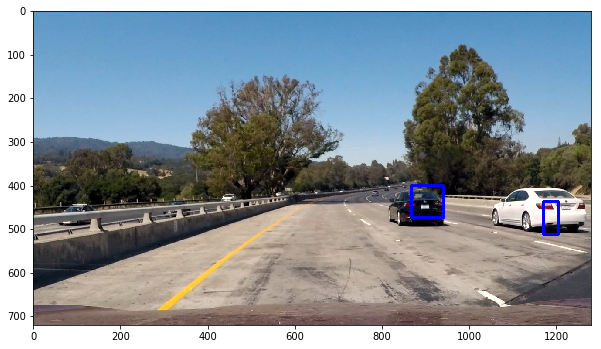

In [13]:
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

### Section 8: Develop Video Pipeline and Filters

In [16]:
last_rectangles = []

def get_cars_in_window(img):
    rects = []
    out_img, boxes = find_cars(img, 400, 475, 1.0, svc, X_scaler, orient, 
                        pixels_per_cell, cell_per_block, spatial_size, histbin)
    rects.extend(boxes)
    #out_img, boxes = find_cars(img, 420, 490, 1.0, svc, X_scaler, orient, 
    #                    pix_per_cell, cell_per_block, spatial_size, histbin)
    #rects.extend(boxes)
    out_img, boxes = find_cars(img, 400, 525, 1.5, svc, X_scaler, orient, 
                        pixels_per_cell, cell_per_block, spatial_size, histbin)
    rects.extend(boxes)
    #out_img, boxes = find_cars(img, 450, 600, 1.5, svc, X_scaler, orient, 
    #                    pix_per_cell, cell_per_block, spatial_size, histbin)
    #rects.extend(boxes)
    out_img, boxes = find_cars(img, 400, 600, 2.0, svc, X_scaler, orient, 
                        pixels_per_cell, cell_per_block, spatial_size, histbin)
    rects.extend(boxes)
    out_img, boxes = find_cars(img, 405, 600, 2.0, svc, X_scaler, orient, 
                        pixels_per_cell, cell_per_block, spatial_size, histbin)
    rects.extend(boxes)
    out_img, boxes = find_cars(img, 400, 545, 1.5, svc, X_scaler, orient, 
                        pixels_per_cell, cell_per_block, spatial_size, histbin)
    rects.extend(boxes)
    out_img, boxes = find_cars(img, 450, 500, 1.0, svc, X_scaler, orient, 
                        pixels_per_cell, cell_per_block, spatial_size, histbin)
    rects.extend(boxes)

    
    return rects


def process(in_img):
    boxes = []
    boxes.extend(get_cars_in_window(in_img))    
    
    good_boxes = []
    for box in boxes:
        # compute area
        area_box = (box[1][0] - box[0][0]) * (box[1][1] - box[0][1])
        if area_box > 5000 and box[0][0] > 700 and box[1][1] < 666 and box[0][1] > 390:
            good_boxes.append(box)
            
    heat = np.zeros_like(in_img[:,:,0]).astype(np.float)
    heat = add_heat(heat,good_boxes)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(in_img), labels)
    
    #replace
    main_boxes = good_boxes
    
    return draw_img, heatmap

def process_continuous(in_img):
    global main_boxes
    boxes = []
    boxes.extend(get_cars_in_window(in_img))    
    
    good_boxes = []
    for box in boxes:
        # compute area
        area_box = (box[1][0] - box[0][0]) * (box[1][1] - box[0][1])
        if area_box > 5000 and box[0][0] > 700 and box[1][1] < 666 and box[0][1] > 390:
            good_boxes.append(box)


    if len(main_boxes) > 0:
        main_boxes.extend(good_boxes)       
    else:
        main_boxes = good_boxes

            
    heat = np.zeros_like(in_img[:,:,0]).astype(np.float)
    heat = add_heat(heat,main_boxes)
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(in_img), labels)
    
    #replace
    main_boxes = good_boxes
    
    return draw_img, heatmap

def process_stream(in_img):
    car_found_img, heatmap_img = process_continuous(in_img)
    return car_found_img



### Section 9: Test Pipeline

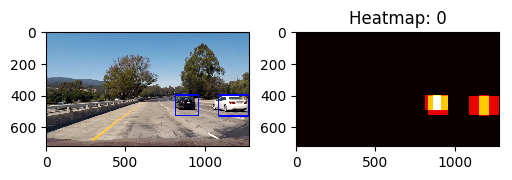

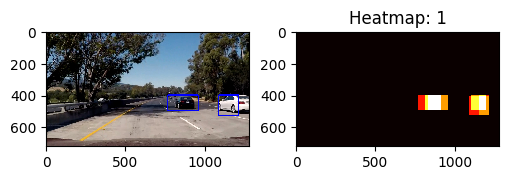

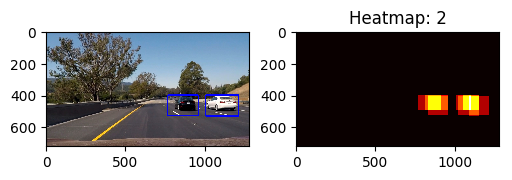

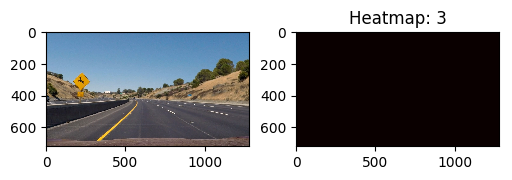

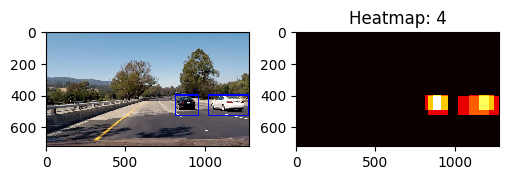

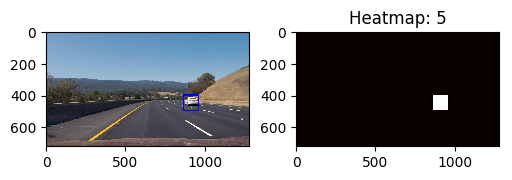

In [17]:
imgs = glob.glob('./test_images/test*.jpg')

for idx, img in enumerate(imgs):
    car_found_img, heatmap_img = process(mpimg.imread(img))
    fig, (before, img_box) = plt.subplots(1, 2, figsize=(5,5), dpi=100)
    plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
    before.imshow(car_found_img)
    img_box.imshow(heatmap_img, cmap='hot')
    plt.title("Heatmap: " + str(idx))
    filename = "output_images/compare-" + str(idx)
    plt.savefig(filename)



### Goal 3: Run your pipeline on a video stream

In [18]:
main_boxes = []
test_out_file = 'video_output.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_stream)
%time clip_test_out.write_videofile(test_out_file, audio=False)


[MoviePy] >>>> Building video video_output.mp4
[MoviePy] Writing video video_output.mp4


 97%|█████████▋| 38/39 [00:14<00:00,  2.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output.mp4 

CPU times: user 16.6 s, sys: 175 ms, total: 16.7 s
Wall time: 15.1 s


In [19]:
main_boxes = []
test_out_file = 'video_output_long.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_stream)
%time clip_test_out.write_videofile(test_out_file, audio=False)


[MoviePy] >>>> Building video video_output_long.mp4
[MoviePy] Writing video video_output_long.mp4


100%|█████████▉| 1260/1261 [08:06<00:00,  2.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output_long.mp4 

CPU times: user 9min 26s, sys: 2.6 s, total: 9min 29s
Wall time: 8min 7s


In [20]:
main_boxes = []
test_out_file = 'video_output_long_p4.mp4'
clip_test = VideoFileClip('p4_output.mp4')
clip_test_out = clip_test.fl_image(process_stream)
%time clip_test_out.write_videofile(test_out_file, audio=False)


[MoviePy] >>>> Building video video_output_long_p4.mp4
[MoviePy] Writing video video_output_long_p4.mp4


100%|█████████▉| 1260/1261 [08:30<00:00,  2.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output_long_p4.mp4 

CPU times: user 9min 52s, sys: 2.93 s, total: 9min 55s
Wall time: 8min 30s
